In [18]:
import h5py
import pandas as pd
import numpy as np

from data.processing import one_hot_encode, reverse_complement

from deepliftmotifs import Trainer
from motifs import DijkMotifs, FimoMotifs, StubMotifs
import numpy as np
import pandas as pd
from modisco.visualization import viz_sequence

from dijk import get_ordered_data_with_annotations
from collections import defaultdict as ddict

from tfhyp import get_hyp_scores
import matplotlib.pyplot as plt

import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def modisco_things(tfmodisco):
    !rm 'tfmodiscoresults.hdf5'
    grp = h5py.File('tfmodiscoresults.hdf5')
    tfmodisco.save_hdf5(grp)
    hdf5_results = h5py.File('tfmodiscoresults.hdf5', 'r')

    print("Metaclusters heatmap")
    import seaborn as sns
    activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                        np.array(
            [x[0] for x in sorted(
                    enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
                   key=lambda x: x[1])])]
    sns.heatmap(activity_patterns, center=0)
    plt.show()

    metacluster_names = [
        x.decode("utf-8") for x in 
        list(hdf5_results["metaclustering_results"]
             ["all_metacluster_names"][:])]

    ids = set()

    all_patterns = []
    for metacluster_name in metacluster_names:
        print(metacluster_name)
        metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                       [metacluster_name])
        print("activity pattern:",metacluster_grp["activity_pattern"][:])
        all_pattern_names = [x.decode("utf-8") for x in 
                             list(metacluster_grp["seqlets_to_patterns_result"]
                                                 ["patterns"]["all_pattern_names"][:])]
        if (len(all_pattern_names)==0):
            print("No motifs found for this activity pattern")
        for pattern_name in all_pattern_names:
            print(metacluster_name, pattern_name)
            all_patterns.append((metacluster_name, pattern_name))
            pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
            #print(pattern["seqlets_and_alnmts"]["seqlets"].value)

            for s in pattern['seqlets_and_alnmts']['seqlets'].value:
                ids.add(int(s.decode().split(',')[0].split(':')[1]))
            background = np.array([0.27, 0.23, 0.23, 0.27])
            print("Task 0 hypothetical scores:")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
            print("Task 0 actual importance scores:")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
            print("onehot, fwd and rev:")
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                            background=background)) 
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                            background=background)) 
    return ids

In [2]:
pd.read_csv('./data/sharpr/sharprFullDataMatrix.tsv', delimiter='\t').iloc[:10].columns

Index(['name', 'chrom', 'center_coord', 'sequence', 'barcode',
       'chromatin_state', 'design', 'k562_minp_rep1_count',
       'k562_minp_rep2_count', 'k562_minp_avg_count', 'k562_sv40p_rep1_count',
       'k562_sv40p_rep2_count', 'k562_sv40p_avg_count',
       'hepg2_minp_rep1_count', 'hepg2_minp_rep2_count',
       'hepg2_minp_avg_count', 'hepg2_sv40p_rep1_count',
       'hepg2_sv40p_rep2_count', 'hepg2_sv40p_avg_count',
       'k562_minp_rep1_norm', 'k562_minp_rep2_norm', 'k562_minp_avg_norm',
       'k562_sv40p_rep1_norm', 'k562_sv40p_rep2_norm', 'k562_sv40p_avg_norm',
       'hepg2_minp_rep1_norm', 'hepg2_minp_rep2_norm', 'hepg2_minp_avg_norm',
       'hepg2_sv40p_rep1_norm', 'hepg2_sv40p_rep2_norm',
       'hepg2_sv40p_avg_norm', 'dna_minp_count', 'dna_sv40p_count'],
      dtype='object')

In [3]:
def get_sharpr_data(size=-1):
    ### rip memory
    data = pd.read_csv('./data/sharpr/sharprFullDataMatrix.tsv', delimiter='\t').iloc[:size]
    
    # cols = ['hepg2_minp_avg_count', 'hepg2_sv40p_avg_count', 'hepg2_minp_avg_norm', 'hepg2_sv40p_avg_norm']
    cols = [c for c in data.columns if 'hepg2' in c and 'avg' not in c]
    indices = [i for i, s in enumerate(data['sequence'].values) if 'N' not in s]
    X_reg = np.stack([one_hot_encode(s) for s in data['sequence'].iloc[indices].values])
    X_comp = np.stack([one_hot_encode(reverse_complement(s)) for s in data['sequence'].iloc[indices].values])
    X = np.zeros((X_reg.shape[0], 2, X_reg.shape[1], X_reg.shape[2]))
    X[:, 0, :, :] = X_reg
    X[:, 1, :, :] = X_comp
    
    Y = data[cols].iloc[indices].values
    return X, Y

In [4]:
x,y = get_sharpr_data(size=100)

In [5]:
t = Trainer(StubMotifs(length=x.shape[0]), X=x, Y=y)

In [8]:
x.shape, y.shape

((10000, 2, 145, 4), (10000, 4))

In [8]:
seqmodel = t.trainFullSequence(epochs=1, input_shape=(145,4), output_shape=8)

(160, 145, 4)
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
160/160 [==============================] - 0s 1ms/step - loss: 11141.7989


In [13]:
hyp_scores = get_hyp_scores(seqmodel, t.X[:,0,:,:])

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02273485886639391
Computing threshold
Thresholds from null dist were -0.28579827029025184  and  0.31203036085935304
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.1902654442541534  and  0.1902654442541534
Final transformed thresholds are -0.97  and  0.97


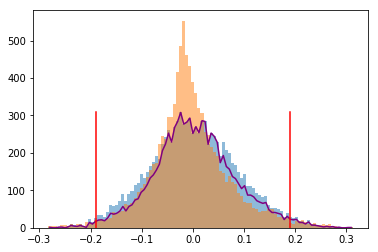

Got 61 coords
After resolving overlaps, got 61 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
61 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


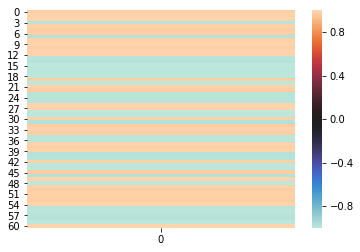

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.022886802596750203
Computing threshold
Thresholds from null dist were -0.2976380840875208  and  0.2509114697691985
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.16068149804120183  and  0.16068149804120183
Final transformed thresholds are -0.97  and  0.97


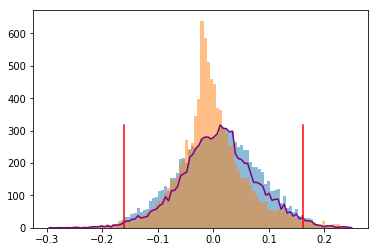

Got 72 coords
After resolving overlaps, got 72 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
72 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


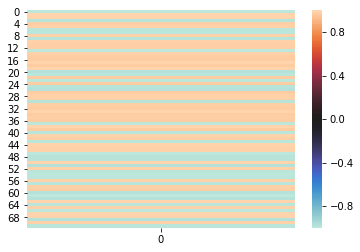

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.02289076292859101
Computing threshold
Thresholds from null dist were -0.33894607976544655  and  0.27850458032917236
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.18543130126886526  and  0.18543130126886526
Final transformed thresholds are -0.97  and  0.97


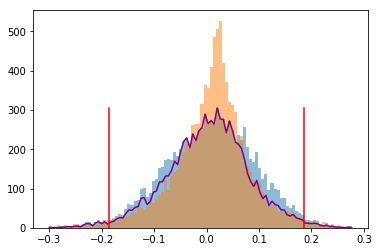

Got 55 coords
After resolving overlaps, got 55 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
55 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


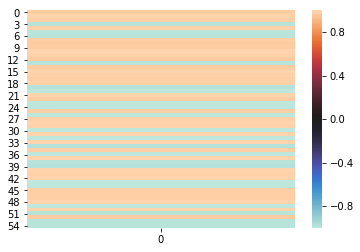

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.03778215515506453
Computing threshold
Thresholds from null dist were -0.31597931543365126  and  0.33802664902759716
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.19518682885111768  and  0.19518682885111768
Final transformed thresholds are -0.97  and  0.97


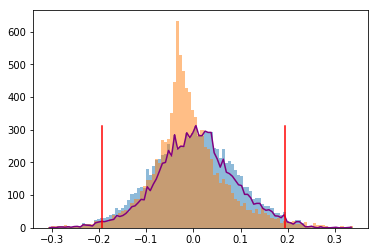

Got 73 coords
After resolving overlaps, got 73 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
73 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


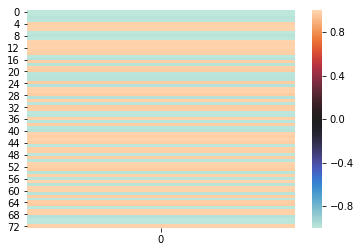

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.01701342451944944
Computing threshold
Thresholds from null dist were -0.4208932460518554  and  0.32802041582763186
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.18852373338668252  and  0.18852373338668252
Final transformed thresholds are -0.97  and  0.97


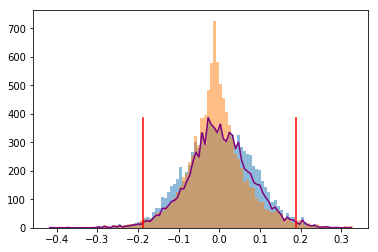

Got 52 coords
After resolving overlaps, got 52 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
52 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


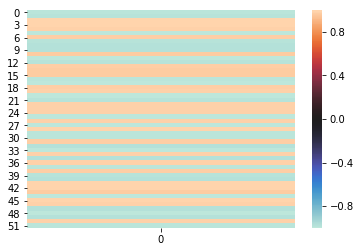

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.03963916458205786
Computing threshold
Thresholds from null dist were -0.29370879438938574  and  0.34485379909747277
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.190840955515974  and  0.190840955515974
Final transformed thresholds are -0.97  and  0.97


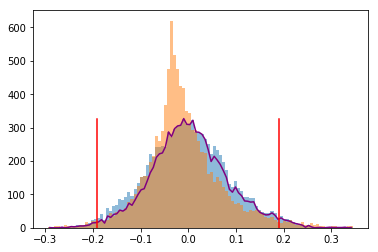

Got 61 coords
After resolving overlaps, got 61 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
61 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


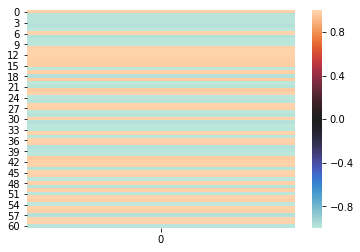

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.018294411447463785
Computing threshold
Thresholds from null dist were -0.241648230078863  and  0.2048727629939094
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.1234667037827312  and  0.1234667037827312
Final transformed thresholds are -0.97  and  0.97


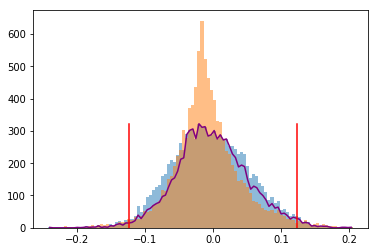

Got 64 coords
After resolving overlaps, got 64 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
64 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


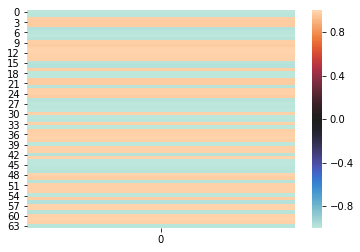

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.009260503511768223
Computing threshold
Thresholds from null dist were -0.3485786679026205  and  0.3206462424306664
Passing windows frac was 0.00016 , which is below  0.03 ; adjusting
Final raw thresholds are -0.20679336995526662  and  0.20679336995526662
Final transformed thresholds are -0.97  and  0.97


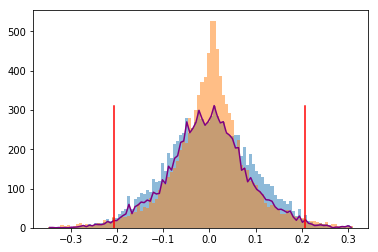

Got 64 coords
After resolving overlaps, got 64 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
64 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}
Metaclusters heatmap


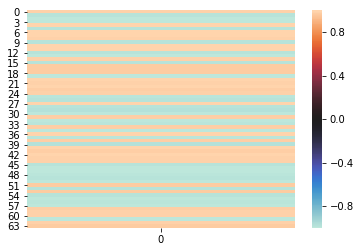

In [19]:
modiscos = []
ids = []
for k in range(len(hyp_scores)):
    scores = hyp_scores[k] * t.X[:,0, :, :]
    # scores = scores.mean(axis=0)
    hypothetical_scores = hyp_scores[k]
    #t.plotDeepLift(scores, num=20, verbose=True)
    tfmodisco = t.tfmodiscoResults(scores, hypothetical_scores)
    modiscos.append(tfmodisco)
    id_list = modisco_things(tfmodisco)
    ids.append(id_list)

In [21]:
s = []
for i in ids:
    s.extend(list(i))
s = set(s)
len(s)

0